# Monte Carlo Simulation

## Why Monte Carlo (MC) simulation?

We use MC simulations for problems where we want to find numerical values, where the process is subject to computational costs.

This is why MCMC (Markov chain Monte Carlo) is used for Bayesian regression -- each parameter space has an exponentially large search space that would be intractable to compute on every possible hypothesis.

Monte Carlo simulation: Repeated random sampling to obtain numerical results.

## Where can we use Monte Carlo methods in ECE?

**Any complex design problem requiring optimization.**  This includes:

- integrating complex functions
- particle filtering problems (state estimation) in signal processing
- analog and digital integrated circuit design
- antenna sensitivity analysis and optimization
- power plant output prediction and forecasting
- telecommunication network design
- risk analysis

We can see how we could even plug in event-based simulation with Monte Carlo simulation!

## Basic steps of a Monte Carlo simulation:

1. Define the model and inputs
2. Randomly generate the inputs using a stochastic process
3. Using the inputs in a deterministic process to produce outputs
4. Aggregating and analyzing the results

### Using MC to numerically obtain the value of $\pi$ with a unit circle

We can numerically obtain the value of $\pi$ by running a MC simulation with the following model:
1. Assuming the [unit circle](https://en.wikipedia.org/wiki/Unit_circle), then we know that everywhere along the unit circle, the hypotenuse is 1: $x^2 + y^2 = 1$.  We also know that the area of a unit circle should be $\pi$, since $a_{circle} = \pi \cdot r^2$.
2. Since our model is simply just $z = x^2 + y^2$, where the constraint for accepted values is $z \le 1$, choose distributions and bounds for the parameters.
3. We assume that the ratio between accepted values and total attempted will be $\pi / 4$, since we are computing the area of the circle as a ratio to the area of the square.
4. Draw samples until the delta of the computed value for $\pi$ between samples is less than some accepted numerical error.

Let's write this up as Python code using `scipy.stats`!  Keep track of the value of the computed $\pi$ between samples so we can plot it!

In [1]:
import numpy as np
import scipy.stats
import timeit
import matplotlib.pyplot as plt
from typing import Union
import pandas as pd

Define the acceptance criteria function:

In [2]:
def circle_accept(x: Union[float, np.ndarray],
                  y: Union[float, np.ndarray]) -> Union[bool, np.ndarray]:
    """
    circle_accept(x, y) will return whether the dart thrown at (x, y)
      is within the area of the unit circle.
    """
    return np.square(x) + np.square(y) <= 1

Define the parameter distributions that we will sample from:

In [3]:
the_rng = np.random.default_rng(7)

x_dist = scipy.stats.uniform(-1, 2)  # Uniform[-1, 1]
y_dist = scipy.stats.uniform(-1, 2)  # Uniform[-1, 1]

x_dist.random_state = the_rng
y_dist.random_state = the_rng

Setup the simulation:

In [89]:
%%timeit -n10

count_accepted = 0
count_total = 0
computed_pis = []

for _ in range(10000):
    x_draw = x_dist.rvs()
    y_draw = y_dist.rvs()
    count_total += 1
    if circle_accept(x_draw, y_draw):
        count_accepted += 1
    pi_estimate = 4 * (count_accepted / count_total)
    computed_pis.append(pi_estimate)

929 ms ± 6.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
print(computed_pis[-4:])

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(0, count_total), computed_pis)

Speeding up the simulation by vectorizing draws:

In [8]:
%%timeit -n10

n_draws = 10000
x_draw = x_dist.rvs(size=n_draws)
y_draw = y_dist.rvs(size=n_draws)

z_accept = circle_accept(x_draw, y_draw)
count_accepted = z_accept.cumsum()

pi_estimate = 4 * (count_accepted / n_draws)
pi_estimate[-1]

552 µs ± 274 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Plotting the scaling of our code against the number of draws:

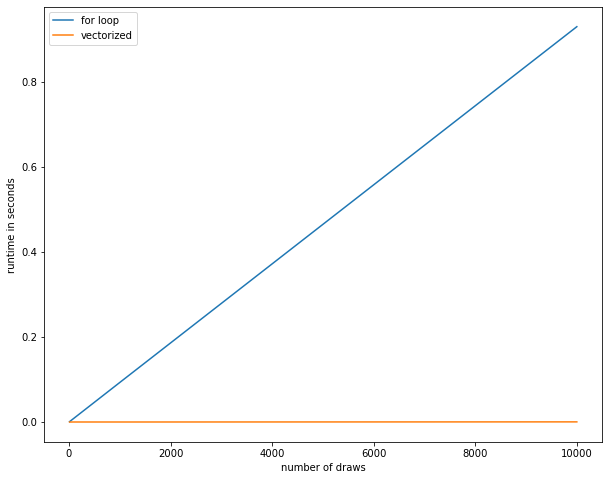

In [102]:
import io

text_table = """
n_draws,t_forloop,t_vector
10,1.05e-3,152e-6
100,9.42e-3,246e-6
1000,93.2e-3,228e-6
10000,929e-3,521e-6
"""

df_scaling = pd.read_csv(io.StringIO(text_table), delimiter=",")
plt.figure(figsize=(10, 8))
plt.plot(df_scaling['n_draws'], df_scaling['t_forloop'], label="for loop")
plt.plot(df_scaling['n_draws'], df_scaling['t_vector'], label="vectorized")
plt.xlabel("number of draws")
plt.ylabel("runtime in seconds")
plt.legend()

### Using MC to generate $\pi$ using Buffon's needles:

![Buffon Pi Method](buffon_pi.png)

1. Assume we drop needles between two lines as a model.  There are two parameters, $D$ and $\theta$.  $D$ is the midpoint distance between the needle dropped and one of the two lines.  $\theta$ is the angle of the rotation of the needle from the line.
2. The needle hitting a line is accepted as $D \le \frac{1}{2} \sin \theta$.  Use a uniform distribution again for $D$ and $\theta$.
3. Since the crossings of $\sin \theta$ are at intervals of $\pi$, then we are effectively looking at the ratio of the area under the curve of $\frac{1}{2} \sin \theta$ compared to a rectangle of $\frac{1}{2}$ by $\pi$.

![Buffon Pi Explained](buffon_pi_exp.png)

4. In this case, what is $\pi$ with relation to the number of hits versus drops?

## Quantifying Monte Carlo error

We can check the accuracy by finding the average of the square distances from the mean, assuming $\pi_c$ is a sequence of computed $\pi$ values:

$\sigma^2 = \frac{1}{N}\sum_i^N ((\pi_{c,i} - \bar{\pi_c})^2) $


## Using Quasi-Monte Carlo (QMC) generators

Because the Uniform distribution only guarantees that the infinite draw will be uniform, sometimes for low draws we do not get uniform samples.  QMC generators are special generators that will yield a "more uniform" uniform distribution.  They are in [`scipy.stats.qmc`](https://docs.scipy.org/doc/scipy/reference/stats.qmc.html#introduction-to-quasi-monte-carlo).

Let's try to use a QMC generator instead of ye olde uniform distribution, and see if we can compute $\pi$ in less draws than above: